In [47]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
#import cv2
import gc
import matplotlib.pyplot as plt
#import openslide
#from openslide.deepzoom import DeepZoomGenerator
import tifffile as tifi
import sklearn
import tensorflow as tf
import seaborn as sns
from PIL import Image
import random

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import vgg16, vgg19, resnet50, mobilenet, inception_resnet_v2, densenet, inception_v3, xception, nasnet, ResNet152V2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adamax
from tensorflow.keras import layers, models, Model
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.layers import Input, Activation,MaxPooling2D, Concatenate, Lambda

from imblearn.over_sampling import RandomOverSampler

#Models of TINTOlib
from TINTOlib.tinto import TINTO
from TINTOlib.supertml import SuperTML
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.barGraph import BarGraph
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.combination import Combination

In [48]:
SEED = 64

# SET RANDOM SEED FOR REPRODUCIBILITY
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [49]:
# Create variable to store dataset name
dataset_name = 'california_housing'

In [50]:
#Select the model and the parameters
pixel = 20
problem_type = "regression"
#image_model = REFINED(problem= problem_type,hcIterations=5)
image_model = TINTO(problem= problem_type, blur=True)
#image_model = IGTD(problem= problem_type)
#image_model = BarGraph(problem= problem_type)
#image_model = DistanceMatrix(problem= problem_type)
#image_model = Combination(problem= problem_type)
#image_model = SuperTML(problem= problem_type)

#Define the dataset path and the folder where the images will be saved
dataset_path = "../sample_data/boston.csv"
images_folder = f"../HyNNImages/Regression/images_{dataset_name}_IGTD"

In [51]:
df = pd.read_csv(f"../Datasets_benchmark/{dataset_name}.csv")

In [52]:
import os

# Generate the images if the folder does not exist
if not os.path.exists(images_folder):
    #Generate thet images
    image_model.generateImages(df, images_folder)
else:
    print("The images are already generated")

img_paths = os.path.join(images_folder,problem_type+".csv")

print(img_paths)

The images are already generated
../HyNNImages/Regression/images_california_housing_IGTD\regression.csv


In [53]:
imgs = pd.read_csv(img_paths)

#imgs["images"]= images_folder + "\\" + imgs["images"]
imgs["images"]= images_folder + "/" + imgs["images"]

In [54]:
combined_dataset = pd.concat([imgs,df],axis=1)
#MEDV is the objective value in Boston dataset
df_x = combined_dataset.drop(df.columns[-1],axis=1).drop("values",axis=1)
df_y = combined_dataset["values"]

print(df_y)

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: values, Length: 20640, dtype: float64


In [55]:
import cv2
X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size = 0.40, random_state = 123)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, random_state = 123)

#TIDY DATA SPLITTED
X_train_num = X_train.drop("images",axis=1)
X_val_num = X_val.drop("images",axis=1)
X_test_num = X_test.drop("images",axis=1)

#IMAGES
# For 3 canal (RGB)
X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

# For 1 canal (GRAY SCALE)
"""X_train_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_test["images"]])"""

attributes = len(X_train_num.columns)
imgs_shape = X_train_img[0].shape

print("Images shape: ",imgs_shape)
print("Attributres: ",attributes)
pixels=X_train_img[0].shape[0]
print("Image size (pixels):", pixels)

Images shape:  (3, 3, 3)
Attributres:  8
Image size (pixels): 3


In [56]:
from sklearn.preprocessing import MinMaxScaler
# Create a MinMaxScaler object
scaler = MinMaxScaler()

In [57]:
# Fit the scaler to the training data and transform it
X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)

# Transform the validation and testing data using the fitted scaler
X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

In [58]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import Sequential
import tensorflow.keras.layers as nn

from tensorflow import einsum
from einops import rearrange, repeat
from einops.layers.tensorflow import Rearrange

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class PreNorm(Layer):
    def __init__(self, fn):
        super(PreNorm, self).__init__()

        self.norm = nn.LayerNormalization()
        self.fn = fn

    def call(self, x, training=True):
        return self.fn(self.norm(x), training=training)

class MLP(Layer):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super(MLP, self).__init__()

        def GELU():
            def gelu(x, approximate=False):
                if approximate:
                    coeff = tf.cast(0.044715, x.dtype)
                    return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
                else:
                    return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

            return nn.Activation(gelu)

        self.net = Sequential([
            nn.Dense(units=hidden_dim),
            GELU(),
            nn.Dropout(rate=dropout),
            nn.Dense(units=dim),
            nn.Dropout(rate=dropout)
        ])

    def call(self, x, training=True):
        return self.net(x, training=training)

class Attention(Layer):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.0):
        super(Attention, self).__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax()
        self.to_qkv = nn.Dense(units=inner_dim * 3, use_bias=False)

        if project_out:
            self.to_out = [
                nn.Dense(units=dim),
                nn.Dropout(rate=dropout)
            ]
        else:
            self.to_out = []

        self.to_out = Sequential(self.to_out)

    def call(self, x, training=True):
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        # dots = tf.matmul(q, tf.transpose(k, perm=[0, 1, 3, 2])) * self.scale
        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = self.attend(dots)

        # x = tf.matmul(attn, v)
        x = einsum('b h i j, b h j d -> b h i d', attn, v)
        x = rearrange(x, 'b h n d -> b n (h d)')
        x = self.to_out(x, training=training)

        return x

class Transformer(Layer):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.0):
        super(Transformer, self).__init__()

        self.layers = []

        for _ in range(depth):
            self.layers.append([
                PreNorm(Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(MLP(dim, mlp_dim, dropout=dropout))
            ])

    def call(self, x, training=True):
        for attn, mlp in self.layers:
            x = attn(x, training=training) + x
            x = mlp(x, training=training) + x

        return x

class ViT(Model):
    def __init__(self, image_size, patch_size, dim, depth, heads, mlp_dim,
                 pool='cls', dim_head=64, dropout=0.0, emb_dropout=0.0):
        """
            image_size: int.
            -> Image size. If you have rectangular images, make sure your image size is the maximum of the width and height
            patch_size: int.
            -> Number of patches. image_size must be divisible by patch_size.
            -> The number of patches is: n = (image_size // patch_size) ** 2 and n must be greater than 16.
            num_classes: int.
            -> Number of classes to classify.
            dim: int.
            -> Last dimension of output tensor after linear transformation nn.Linear(..., dim).
            depth: int.
            -> Number of Transformer blocks.
            heads: int.
            -> Number of heads in Multi-head Attention layer.
            mlp_dim: int.
            -> Dimension of the MLP (FeedForward) layer.
            dropout: float between [0, 1], default 0..
            -> Dropout rate.
            emb_dropout: float between [0, 1], default 0.
            -> Embedding dropout rate.
            pool: string, either cls token pooling or mean pooling
        """
        super(ViT, self).__init__()

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.patch_embedding = Sequential([
            Rearrange('b (h p1) (w p2) c -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.Dense(units=dim)
        ], name='patch_embedding')

        self.pos_embedding = tf.Variable(initial_value=tf.random.normal([1, num_patches + 1, dim]))
        self.cls_token = tf.Variable(initial_value=tf.random.normal([1, 1, dim]))
        self.dropout = nn.Dropout(rate=emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool

    def call(self, img, training=True, **kwargs):
        x = self.patch_embedding(img)
        b, n, d = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = tf.concat([cls_tokens, x], axis=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x, training=training)

        x = self.transformer(x, training=training)

        if self.pool == 'mean':
            x = tf.reduce_mean(x, axis=1)
        else:
            x = x[:, 0]

        return x

In [59]:
# ViT + MLP

# ViT branch
vit_input = Input(shape=(3, 3, 3))

vit_model = ViT(
    image_size = 3,
    patch_size = 3,
    dim = 64,
    depth = 2,
    heads = 4,
    mlp_dim = 128,
    dropout = 0.1,
    emb_dropout = 0.1
)

# ViT branch
vit_input = Input(shape=(3, 3, 3))

# Wrap the ViT model call in a Lambda layer
vit_output = Lambda(lambda x: vit_model(x), output_shape=(64,))(vit_input)

vit_output = Dense(32, activation='relu')(vit_output)
vit_output = Dense(16, activation='relu')(vit_output)

# MLP branch
mlp_input = Input(shape=(8,))
mlp_output = Dense(16, activation='relu')(mlp_input)
mlp_output = Dense(32, activation='relu')(mlp_output)
mlp_output = Dense(16, activation='relu')(mlp_output)

# Concatenate the outputs of CNN and MLP branches
concat_output = Concatenate()([vit_output, mlp_output])

# Final MLP
final_output = Dense(32, activation='relu')(concat_output)
final_output = Dense(16, activation='relu')(final_output)
final_output = Dense(8, activation='relu')(final_output)
final_output = Dense(1)(final_output)  # Output layer for regression

# Create the hybrid model
model = Model(inputs=[mlp_input, vit_input], outputs=final_output)

In [60]:
model.summary()

Model: "functional_56"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_59      │ (None, 3, 3, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_60      │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 64)        │          0 │ input_layer_59[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_140 (Dense)   │ (None, 16)        │        144 │ input_layer_60[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_138 (Dense)   │ (None, 32)        │      2,080 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_141 (Dense)   │ (None, 32)        │        544 │ dense_140[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_139 (Dense)   │ (None, 16)        │        528 │ dense_138[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_142 (Dense)   │ (None, 16)        │        528 │ dense_141[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32)        │          0 │ dense_139[0][0],  │
│ (Concatenate)       │                   │            │ dense_142[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_143 (Dense)   │ (None, 32)        │      1,056 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_144 (Dense)   │ (None, 16)        │        528 │ dense_143[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_145 (Dense)   │ (None, 8)         │        136 │ dense_144[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_146 (Dense)   │ (None, 1)         │          9 │ dense_145[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,553 (21.69 KB)

 Trainable params: 5,553 (21.69 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
import tensorflow.keras.backend as K

def r_square(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2

METRICS = [
    tf.keras.metrics.MeanSquaredError(name = 'mse'),
    tf.keras.metrics.MeanAbsoluteError(name = 'mae'),
    tf.keras.metrics.RootMeanSquaredError(name = 'rmse'),
    r_square,
]

In [62]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    min_delta=0.001,     # Minimum change in the monitored quantity to qualify as an improvement
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Print messages when the callback takes an action
    mode='min'           # Training will stop when the quantity monitored has stopped decreasing
)


In [63]:
from tensorflow.keras.optimizers import RMSprop

In [64]:
opt = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)
opt = Adam(learning_rate=0.001)

In [65]:
model.compile(
    loss="mse",
    optimizer=opt,
    metrics = METRICS
)

In [66]:
model_history=model.fit(
    x=[X_train_num,X_train_img], y=y_train,
    validation_data=([X_val_num,X_val_img], y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50


387/387 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.6007 - mae: 0.9480 - mse: 1.6007 - r_square: -0.2292 - rmse: 1.2371 - val_loss: 0.5576 - val_mae: 0.5335 - val_mse: 0.5576 - val_r_square: 0.5659 - val_rmse: 0.7467
Epoch 2/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5812 - mae: 0.5600 - mse: 0.5812 - r_square: 0.5354 - rmse: 0.7622 - val_loss: 0.5359 - val_mae: 0.5188 - val_mse: 0.5359 - val_r_square: 0.5827 - val_rmse: 0.7321
Epoch 3/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5533 - mae: 0.5426 - mse: 0.5533 - r_square: 0.5579 - rmse: 0.7437 - val_loss: 0.5291 - val_mae: 0.5026 - val_mse: 0.5291 - val_r_square: 0.5890 - val_rmse: 0.7274
Epoch 4/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5353 - mae: 0.5318 - mse: 0.5353 - r_square: 0.5721 - rmse: 0.7315 - val_loss: 0.5086 - val_mae: 0.4986 - val_mse: 0.5086 - val_r_square: 0.6039 - val_rmse: 0.7132
Epoch 5/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5221 - mae: 0.5242 - mse: 0.5221 - r_square:

rmse: 0.4252
- Patch size de 3: 0.4135, no es necesario ir de pixel en pixel, imagenes pequenas es posible usar un patch size grande.

In [67]:
os.makedirs("models/ViT+MLP_Regression", exist_ok=True)
model.save(f"models/ViT+MLP_Regression/model_{dataset_name}.keras")

In [68]:
print(model_history.history.keys())

dict_keys(['loss', 'mae', 'mse', 'r_square', 'rmse', 'val_loss', 'val_mae', 'val_mse', 'val_r_square', 'val_rmse'])


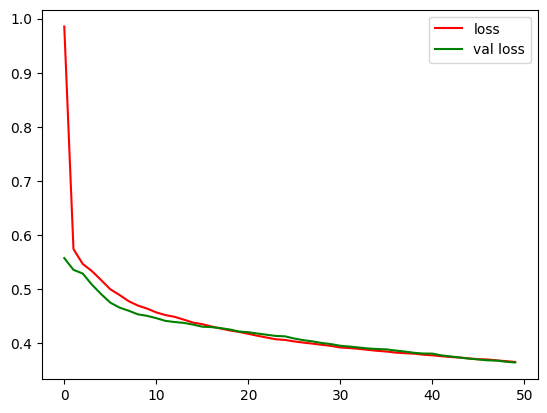

In [69]:
plt.plot(model_history.history['loss'], color = 'red', label = 'loss')
plt.plot(model_history.history['val_loss'], color = 'green', label = 'val loss')
plt.legend(loc = 'upper right')
plt.show()

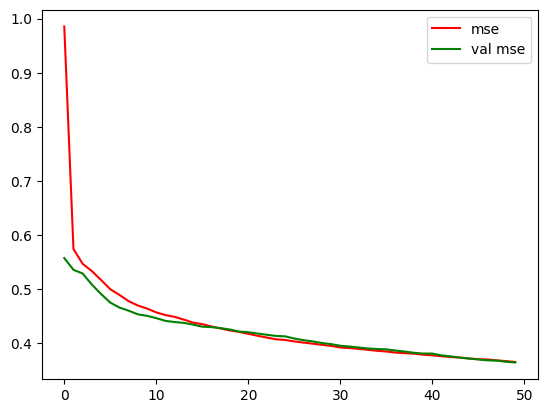

In [70]:
plt.plot(model_history.history['mse'], color = 'red', label = 'mse')
plt.plot(model_history.history['val_mse'], color = 'green', label = 'val mse')
plt.legend(loc = 'upper right')
plt.show()

In [72]:
# Evaluate the model on the training set and collect scores for custom metrics
train_scores = model.evaluate([X_train_num,X_train_img], y_train)

# Evaluate the model on the validation set and collect scores for custom metrics
val_scores = model.evaluate([X_val_num,X_val_img], y_val)

score_test= model.evaluate([X_test_num,X_test_img], y_test)

# Save training and validation scores for custom metrics
metrics = {
    'train_loss': train_scores[0],
    'train_mse': train_scores[1],
    'train_mae': train_scores[2],
    'train_rmse': train_scores[3],
    'train_r2': train_scores[4],
    'val_loss': val_scores[0],
    'val_mse': val_scores[1],
    'val_mae': val_scores[2],
    'val_rmse': val_scores[3],
    'val_r2': val_scores[4],
    'test_loss': score_test[0],
    'test_mse': score_test[1],
    'test_mae': score_test[2],
    'test_rmse': score_test[3],
    'test_r2': score_test[4]
}

 17/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3322 - mae: 0.4201 - mse: 0.3322 - r_square: 0.7140 - rmse: 0.5760 

387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3455 - mae: 0.4111 - mse: 0.3455 - r_square: 0.7234 - rmse: 0.5877
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3631 - mae: 0.4205 - mse: 0.3631 - r_square: 0.7162 - rmse: 0.6023
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3235 - mae: 0.4077 - mse: 0.3235 - r_square: 0.7283 - rmse: 0.5680


In [73]:
# Save metrics to a file
os.makedirs('logs/ViT+MLP_Regression', exist_ok=True)
with open(f'logs/ViT+MLP_Regression/{dataset_name}_metrics.txt', 'w') as f:
    for key, value in metrics.items():
        f.write(f'{key}: {value}\n')